In [2]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.special import gammaln

from scipy.signal import find_peaks
#%matplotlib qt5
%matplotlib inline
from scipy.signal import argrelmin

from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from sklearn.metrics import r2_score

def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed






def minimos_locales(dfg , degree , smooth =  False):
    
    if smooth == False:
        t = np.array(dfg.t) 
        v = np.array(dfg.v) 
    elif smooth == True:
        t = smoothTriangle(np.array(dfg.t) ,  degree)
        v = smoothTriangle(np.array(dfg.v) ,  degree)

    dv_dt=(np.diff(v ) )/ (np.diff(t ) )

    a = dv_dt * np.roll(dv_dt , 1)

    tmins = np.argwhere(a < 0)



    return tmins


def filtro_peaks(peaks_ar , ancho_campana):
    peaks_ar_ =  peaks_ar.reshape((1,len(peaks_ar)))[0].tolist()
    #busca picos con distancia mayor a 260 entre ellos
    singular_peaks = np.argwhere(np.diff(peaks_ar_) > ancho_campana).reshape((1 , len(np.argwhere(np.diff(peaks_ar_) > ancho_campana))))
    
    return peaks_ar[singular_peaks]

import seaborn as sns
sns.set_style('whitegrid')

umbral_v = 0.00197 #this comes from estimating the end of the noise distribution and the start of photon counts in the signal


# bring in lab measurments 

In [50]:
#bring in signals from lab measurments

frames = os.listdir('25nanoseg_6vreal') 
len(frames)

10000

In [54]:
dist_eventos2  =  []

for frame in frames:
    if frame.endswith('.txt'): 
        frame_df = pd.read_csv(f'25nanoseg_6vreal/{frame}')
        
        signal = np.array(frame_df.v)
        peaks_ar = minimos_locales(frame_df , 50 , smooth = True) #locate peaks
        singular_peaks_ar=  filtro_peaks(peaks_ar , 150)[0] #filter peaks
        peaks = signal[singular_peaks_ar]

        cantidad_eventos_frame = (peaks < - umbral_v  ).sum() #using 'umbral_v' to discriminate noise from photon counts

        dist_eventos2.append(cantidad_eventos_frame)
        

df_eventos= pd.Series(dist_eventos2)
len(df_eventos)


C:\Users\lucas\AppData\Local\Temp/ipykernel_984/3484057293.py:12: RuntimeWarning: invalid value encountered in true_divide
  dv_dt=(np.diff(v ) )/ (np.diff(t ) )


10000

# plot histogram for the amount of photon counts in one oscilloscope screen

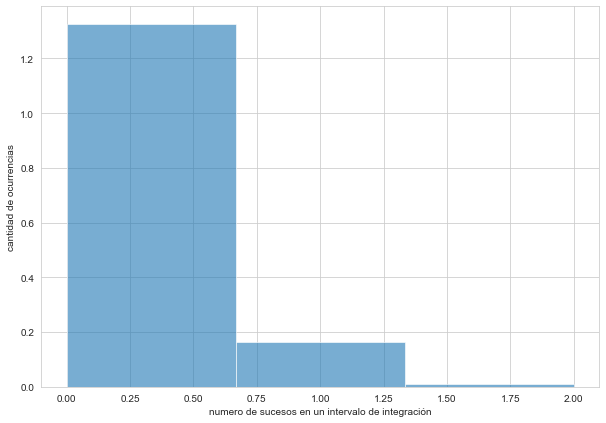

In [5]:
plt.figure(figsize = (10,7))

n , bins, patches = plt.hist(df_eventos , bins = int(len(df_eventos.unique())), alpha= 0.6 , density = True );
plt.xlabel('numero de sucesos en un intervalo de integración')
plt.ylabel('cantidad de ocurrencias')

count, division = np.histogram(df_eventos ,bins = int(len(df_eventos.unique())) +1, density = True)


In [7]:
#saving histogram data as variables
x_numero_eventos = np.array(df_eventos.value_counts(normalize=True).sort_index().index.to_numpy())
y_cantidad = np.array(df_eventos.value_counts(normalize=True).sort_index().values)


[0 1 2]
[0.883 0.109 0.008]


# poisson with curve fit

here we use curvefit to fit data to a Poisson distribution

In [8]:

#Poisson distribution function
#probability mass function, lamda = E[x] = var[x]
#p(x = k) = lamda**k * exp(-lamda) / k!

def pois(k , lamb):
    return ( lamb**np.array(k) ) * np.exp(- lamb) / factorial(np.array(k))


In [9]:
#fitting data
params, cov = curve_fit(pois, x_numero_eventos, y_cantidad )

perr = np.sqrt(np.diag(cov))

r2 = r2_score(y_cantidad ,  pois(x_numero_eventos , params[0]))
print('lambda poisson ' ,params)
print('error poisson ' , perr)

print('r2 ', r2)

lambda poisson  [0.12403065]
error poisson  [0.00082557]
r2  0.9999958667747971


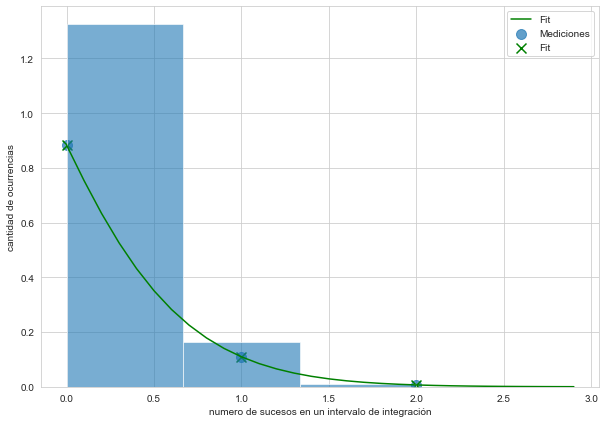

In [11]:
#plotting data with fit
plt.figure(figsize = (10,7))
plt.xlabel('numero de sucesos en un intervalo de integración')
plt.ylabel('cantidad de ocurrencias')

plt.scatter(x_numero_eventos, y_cantidad , label = 'Mediciones' , s = 100 , alpha = 0.7)
n , bins, patches = plt.hist(df_eventos , bins = int(len(df_eventos.unique()) ), alpha= 0.6 , density = True );
plt.scatter(x_numero_eventos, pois(x_numero_eventos , params[0]) , label = 'Fit' ,s = 100 , marker = 'x' , color = 'green' , )
plt.plot(np.arange(0 , len(x_numero_eventos) , 0.1), pois(np.arange(0 , len(x_numero_eventos) , 0.1) , params[0]) , label = 'Fit' , color = 'green' , )

plt.legend()


# using scipy 
another aproach for fitting data to a Poisson distribution: use the scipy functions for the Poisson distribution.
The MLE of the Poisson parameter is the sample mean.

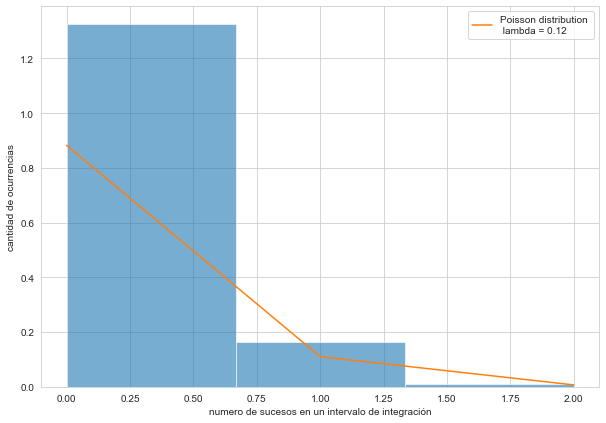

In [37]:
from scipy.stats import poisson

guess = sum(x_numero_eventos*y_cantidad) #estimation of expected value for the distribution
pois_probs = poisson.pmf(x_numero_eventos, mu=guess) #generate Poisson distribution with guess

plt.figure(figsize = (10,7))

n , bins, patches = plt.hist(df_eventos , bins = int(len(df_eventos.unique())) , alpha= 0.6 , density = True );
plt.xlabel('numero de sucesos en un intervalo de integración')
plt.ylabel('cantidad de ocurrencias') 

plt.plot((x_numero_eventos)  , pois_probs, label = f'Poisson distribution \n lambda = {round(guess ,2)}')

plt.legend()


# Bose-Einstein con curve fit

fitting data to a Bose-Einstein distribution


In [29]:
def bose( k , lamda):
    return ( lamda**k )/ ( 1  + lamda )**(1 + k)

In [30]:
paramsbose, covbose = curve_fit(bose, x_numero_eventos, y_cantidad)

perrbose = np.sqrt(np.diag(covbose))

r2bose = r2_score(y_cantidad ,  bose(x_numero_eventos , paramsbose[0]))
print('lambda bose ' , paramsbose)
print('error bose  ',perrbose)

print('r2 ', r2bose)

lambda bose  [0.13530709]
error bose   [0.00460372]
r2  0.9999098985305952


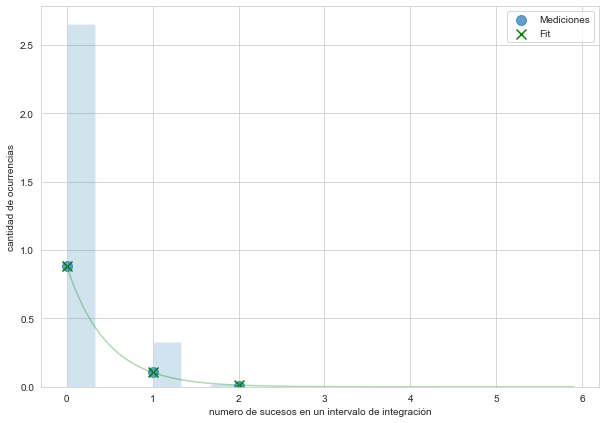

In [31]:
plt.figure(figsize = (10,7))
plt.xlabel('numero de sucesos en un intervalo de integración')
plt.ylabel('cantidad de ocurrencias')


plt.scatter(x_numero_eventos, y_cantidad , label = 'Mediciones' , s = 100 , alpha = 0.7)
plt.scatter(x_numero_eventos, bose(x_numero_eventos , paramsbose[0]) , label = 'Fit' ,s = 100 , marker = 'x' , color = 'green' , )

plt.plot(np.arange(0 , 6,0.1), bose(np.arange(0 , 6,0.1) , paramsbose[0]) , alpha = 0.3, color = 'g')

plt.hist(df_eventos , bins = 6 , density = True , alpha = 0.2);


plt.legend()